# Chargement des datas


In [1]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math

start_time = datetime.datetime.now()

In [2]:
# connection à la db
con = duckdb.connect(database="./../../database/data.duckdb", read_only=True)

In [3]:
# récupération de la liste des tables de la db
con.execute("SHOW TABLES").df()

,name
0,edc_communes
1,edc_prelevements
2,edc_resultats
3,sise_communes
4,sise_prelevements
5,sise_resultats


In [4]:
# chargement des tables dans des df pour les datas de 2024 (patience requise)
prelevements = con.execute("SELECT * FROM edc_prelevements WHERE de_partition = 2024").df()
resultats = con.execute("SELECT * FROM edc_resultats WHERE de_partition = 2024").df()
communes = con.execute("SELECT * FROM edc_communes WHERE de_partition = 2024").df()
resultats_shape = resultats.shape

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [5]:
con.close()

# Analyse des résultats

On cherche à déterminer pour chaque résultat si ce dernier fait l'objet d'un ou plusieurs seuils à respecter, et, si c'est le cas, à déterminer si le résultat est en dehors de ce(s) seuil(s).

Dans la documentation officielle du dataset, on peut voir qu'il y a 2 champs faisant référence à ces seuils :  
refqual : Référence(s ) de qualité du paramètre concerné en vigueur au moment du prélèvement pour le type d’eau considéré.  
limitequal : Limite(s) de qualité du paramètre concerné en vigueur au moment du prélèvement pour le type d’eau considéré.

On commence par établir le format et la liste des différents seuils existants.

#### Analyse des seuils

In [6]:
liste_seuils_refqual = resultats['refqual'].dropna().unique()
print(f"Nombre de seuils 'refqual' uniques non nul: {len(liste_seuils_refqual)}\n")
print("Liste des seuils 'refqual' :\n"+"\n".join(i for i in liste_seuils_refqual))
print('')

liste_seuils_limitequal = resultats['limitequal'].dropna().unique()
print(f"Nombre de seuils 'limitequal' uniques non nul: {len(liste_seuils_limitequal)}\n")
print("Liste des seuils 'limitequal' :\n"+"\n".join(i for i in liste_seuils_limitequal))

Nombre de seuils 'refqual' uniques non nul: 27

Liste des seuils 'refqual' :
<=200 µg/L
>=6,5 et <=9 unité pH
<=25 °C
<=0 n/(100mL)
>=200 et <=1100 µS/cm
<=15 mg(Pt)/L
<=0,1 mg/L
<=2 NFU
<=1 mg/L
<=50 µg/L
<=0,2 mg/L
<=250 mg/L
<=2 mg(C)/L
<=100 Bq/L
<=100.0 Bq/L
<=0,7 mg/L
>=1 et <=2 SANS OBJET
<=0,1 mSv/a
<=200 mg/L
<=0,5 NFU
<=5 mg(O2)/L
<=0 NPP/100mL
<=3 n
<=0.2 mg/L
<=0,5 mg/L
>=180 et <=1000 µS/cm
<=700 µg/L

Nombre de seuils 'limitequal' uniques non nul: 35

Liste des seuils 'limitequal' :
<=0 n/(100mL)
<=0.1 µg/L
<=0.01 µg/L
<=5 µg/L
<=0.5 µg/L
<=50 µg/L
<=2 mg/L
<=0,1 µg/L
<=20 µg/L
<=0,5 mg/L
<=10 µg/L
<=50 mg/L
<=1 mg/L
<=100 µg/L
<=0,25 mg/L
<=0,7 mg/L
<=0,1 mg/L
<=0,03 µg/L
<=0,5 µg/L
<=3 µg/L
<=1 µg/L
<=1,5 mg/L
<=50 µg(CN)/L
<=6 µg/L
<=5 NG/(KG POIDS CORPOREL/J)
<=1 NFU
<=0 NPP/100mL
<=30 µg/L
<=250 µg/L
<=700 µg/L
<=2,5 µg/L
<=2,4 mg/L
<=0,1 ng/L
<=50.0 µg/L
<=60 µg/L


On constate que tous les seuils sont exprimés en <= ou >=, et on remarque également qu'il faudra convertir les ',' en '.' pour que python puissent interpréter les valeurs de seuils en nombre.

Tous les seuils sont en format texte et contiennent l'unité, à l'exception du seuil ">=1 et <=2 SANS OBJET" qui attire l'attention.  
On regarde quels paramètres sont concernés par ce seuil atypique.

In [7]:
params = resultats[resultats['refqual'] == '>=1 et <=2 SANS OBJET']['libminparametre'].unique()
print(f"Paramètres utilisant le seuil ''>=1 et <=2 SANS OBJET'' : {params}")

Paramètres utilisant le seuil ''>=1 et <=2 SANS OBJET'' : ['Equilibre calcocarbonique 0/1/2/3/4']


Etrange. On va approfondir le fonctionnement de ce seuil en analysant les différents types de résultats possibles pour ce paramètre. Pour cela on va observer les champs "rqana" et "valtraduite" qui sont respectivement le résultat et le résultat traduit en valeur numérique.

In [8]:
resultat_equilibre_calcocarbonique = resultats[resultats['libminparametre'] == 'Equilibre calcocarbonique 0/1/2/3/4']
resultat_equilibre_calcocarbonique[['libminparametre','rqana','valtraduite']].drop_duplicates().sort_values('valtraduite')

,libminparametre,rqana,valtraduite
19490,Equilibre calcocarbonique 0/1/2/3/4,Eau incrustante,0.0
9464,Equilibre calcocarbonique 0/1/2/3/4,Légèrement incrustante,1.0
6683,Equilibre calcocarbonique 0/1/2/3/4,A l'équilibre,2.0
7728,Equilibre calcocarbonique 0/1/2/3/4,"Légèrement agressive 0,2>D>0,3",3.0
41766,Equilibre calcocarbonique 0/1/2/3/4,Eau agressive,4.0


Le résultat donnée est une valeur qualitative allant de 0 à 4 et passant par une valeur d'équilibre à 2. Le "SANS OBJET" semble faire référence à l'absence d'unité. Comme on est dans un cas de valeur qualitative, on va mettre de coté ce seuil et il ne sera plus considéré dans le reste de l'analyse sur les valeurs quantitatives.

On revient à l'analyse générale des seuils. Comme indiqué précédemment, l'unité est présente dans la définition du seuil. Comme on a un champ correspondant à l'unité de la mesure dans les datas (cdunitereferencesiseeaux), on va vérifier que toutes les mesures sont bien dans l'unité du seuil, lorsque celui ci existe.

In [9]:
# obsolète
## on créé un subset qui contient tous les résultats refqual ayant un seuil valide
#résultats_avec_seuil_refqual_valide = resultats[(resultats['refqual'] != '>=1 et <=2 SANS OBJET') & (resultats['refqual'].isna() == False)]
## on établit la liste des résultats dont la valeur du champ d'unité (cdunitereferencesiseeaux) n'est pas strictement inclus dans la valeur du seuil
#val = résultats_avec_seuil_refqual_valide[~résultats_avec_seuil_refqual_valide.apply(lambda x: x.cdunitereferencesiseeaux in x.refqual, axis=1)].shape[0]
#print(f"Nombre de résultats avec unité de la mesure différent de l'unité du seuil refqual: {val}")

# on créé un subset qui contient tous les résultats limitequal ayant un seuil valide
résultats_avec_seuil_limitequal_valide = resultats[resultats['limitequal'].isna() == False]
# on établit la liste des résultats dont la valeur du champ d'unité (cdunitereferencesiseeaux) n'est pas strictement inclus dans la valeur du seuil
val = résultats_avec_seuil_limitequal_valide[~résultats_avec_seuil_limitequal_valide.apply(lambda x: x.cdunitereferencesiseeaux in x.limitequal, axis=1)].shape[0]
print(f"Nombre de résultats avec unité de la mesure différent de l'unité du seuil limitequal: {val}")

Nombre de résultats avec unité de la mesure différent de l'unité du seuil limitequal: 0


Bonne nouvelle : tous les résultats sont de l'unité correspondant au seuil, il n'y aura donc pas besoin de faire de conversions sur les résultats. 

On va séparer le dataset en 2 subsets pour le reste de l'analyse : 
- un subset contenant les entrées ayant au moins une valeur refqual valide ou une valeur limitequal sur lequel portera l'analyse des seuils
- un subset contenant les autres entrées sur lequel portera une analyse différente

In [10]:
resultats_avec_seuil_valide = resultats[(resultats['limitequal'].isna() == False) | ((resultats['refqual'] != '>=1 et <=2 SANS OBJET') & (resultats['refqual'].isna() == False))].copy()
resultats_sans_seuil_valide = resultats[(resultats['limitequal'].isna()) & ((resultats['refqual'] == '>=1 et <=2 SANS OBJET') | (resultats['refqual'].isna()))].copy()

# On vérifie qu'on n'a oublié aucune entrée
print(resultats.shape[0] == resultats_avec_seuil_valide.shape[0] + resultats_sans_seuil_valide.shape[0])

# on détruit les dataframes pour récupérer de la mémoire
del resultats, résultats_avec_seuil_limitequal_valide

True


#### Analyse des résultats

Les résultats étant au format string, on observe les premières entrées.

In [11]:
resultats_avec_seuil_valide['rqana'].head()

0     <10
7      10
11    7,6
12    8,0
14     <1
Name: rqana, dtype: object

Vérifions également si on a des valeurs nulles.

In [12]:
print(f"Nombre de valeurs nulles : {resultats_avec_seuil_valide['rqana'].isna().sum()}")

Nombre de valeurs nulles : 399


On remarque qu'on a déjà 2 soucis : les "," qu'il va falloir remplacer en "." pour que python puisse convertir les valeurs en float, et la présence de résultat sous la forme "<X". On va partir du principe qu'il existe également des résultat sous la forme ">X". Vérifions maintenant si on a d'autres formes de résultats.

In [13]:
print('Liste des valeurs de résultats non convertibles en float :')
t = resultats_avec_seuil_valide.loc[resultats_avec_seuil_valide['rqana'].isna() == False,'rqana'].unique()
l = []
for i in t:
    try:
        float(i.replace(',','.'))
    except:
        if (i[0] != '<') & (i[0] != '>'):
            try:
                float(i[1:].replace(',','.'))
            except:
                print(i)
                l.append(i)
print('\nNombre d\'occurences :',resultats_avec_seuil_valide['rqana'].apply(lambda x: x in l).sum())

Liste des valeurs de résultats non convertibles en float :
N.M.
ILLISIBL
INCOMPT.
N.D.
PRESENCE
?
TRACES

Nombre d'occurences : 36303


Sur la doc officielle du dataset, on peut trouver un tableau de conversion pour ces valeurs, selon des règles qui peuvent être parfois douteuse. Etant donné le faible nombre d'occurences, on va décider de considérer comme invalide ces valeurs pour le reste de l'étude.

Pour récapituler, on a différent types de résultat : numérique, de la forme <X, de la forme >X, et invalide ou nul.

On peut maintenant chercher à déterminer pour chaque résultat, lorsqu'il est valide, s'il est hors seuil(s) ou non.

#### Analyse des résultats hors seuils

A noter que seul les paramètres de type "quantitatif" possèdent des seuils (à l'exception de l'Equilibre calcocarbonique comme vu précédemment). On s'occupera des paramètres de type "qualitatif" dans une autre analyse.

On distingue 3 cas : 
1°) le résultats est un nombre  
2°) le résultat est < ou > à un nombre  
3°) le résultat ou le seuil est invalide

Pour le cas 1°), on a juste à appliquer la logique du ou des seuils correspondant.  
Pour le cas 3°), on ne peut simplement pas conclure puisque le résultat ou le seuil n'est pas exploitable.  
Pour le cas 2°), on peut soit conclure, soit être dans l'impossibilité de conclure

Exemples possibles pour 2°) : 
- résultat '<10' avec seuil '>=5' => incertain donc impossible à conclure
- résultat '<10' avec seuil '<=5' => incertain donc impossible à conclure
- résultat '<10' avec seuil '<=15' => dans le seuil
- résultat '<10' avec seuil '>=15' => hors seuil
- résultat '>10' avec seuil '>=5' => dans le seuil
- résultat '>10' avec seuil '<=5' => hors seuil
- résultat '>10' avec seuil '<=15' => incertain donc impossible à conclure
- résultat '>10' avec seuil '>=15' => incertain donc impossible à conclure

Je peux donc appliquer la logique suivante :  
Soit R le résultat, Vr la valeur du résultat, S le seuil et Vs la valeur du seuil.  
Si Vs R = True alors le résultat est impossible à conclure.  
Sinon, si Vr S  = True alors le résultat est dans le seuil, sinon il est hors seuil.  

Exemple avec résultat '<10' et seuil '>=5' :  
Vs R = '5 <10' = True => impossible à conclure

Exemple avec résultat '>10' et seuil '>=5' :  
Vs R = '5 >10' = False  
Vr S = '10 >5' = True => dans le seuil

Exemple avec résultat '<10' et seuil '>=15' :  
Vs R = '15 <10' = False  
Vr S = '10 >15' = False => hors seuil

Note : dans le cas de plusieurs seuils, Vs R = True doit être vérifié pour au moins 1 seuil.  
Afin d'éviter le cas particulier ou la valeur du seuil est égal à la valeur du résultat, on considèrera un résultat sous la forme <X égal à 0.9999X et un résultat sous la forme >X égal à 1.0001X lors du test 'Vr S'

Pour chaque ligne du dataset, on va donc déterminer si le résultat est :
- dans le(s) seuil(s)
- hors de(s) seuil(s)
- impossible à conclure

In [14]:
def is_result_within_threshold(result, threshold):
    def get_logic(string,symbol): # récupération de l'opération logique en fonction du symbole recherché
        try:
            index = string.find(symbol)
            if index != -1:
                s = string[index:]
                logic = s[:s.find(' ')].replace(',','.')

                for c in logic:
                    if c.isnumeric():
                        try:
                            Vs = float(logic[logic.find(c):])
                        except:
                            Vs = None
                            logic = None
                        break
            else:
                logic = None
                Vs = None
            return logic, Vs
        except:
            return None, None

    # traitement du résultat
    try:
        result = result.replace(',','.')
    except: # cas où résultat nul
        return None
    
    try:
        Vr = float(result)
        cas = 1
    except:
        if (result[0] == '<'):
            try:
                Vr = float(result[1:]) * 0.9999
                cas = 2
            except:
                Vr = None
        elif (result[0] == '>'):
            try:
                Vr = float(result[1:]) * 1.0001
                cas = 2
            except:
                Vr = None
        else:
            Vr = None
    # traitement du seuil
    # on chercher d'abord la logique du seuil avec symbole <=
    logic_inf, logic_inf_Vs = get_logic(threshold,'<=')
    # puis on cherche ensuite la logique du seuil avec sympbole >=
    logic_sup, logic_sup_Vs = get_logic(threshold,'>=')
   
    if (Vr != None):
        match cas:
            # 1er cas : si le résultat est un nombre fixe, on lui applique directement la logique du(des) seuil(s)
            case 1: 
                # on applique les logiques en fonctions de si elles existent 
                if (logic_inf != None) & (logic_sup != None):
                    logic = '(Vr'+logic_inf+') & (Vr'+logic_sup+')'
                elif (logic_inf != None):
                    logic = 'Vr'+logic_inf
                elif (logic_sup != None):
                    logic = 'Vr'+logic_sup
                else:
                    logic = 'None'
                return(eval(logic)) # retourne True si dans le seuil, False si hors du seuil, et None si impossible à conclure
            case 2: # 2eme cas, on test 'Vs R'
                if (logic_inf != None) & (logic_sup != None):
                    logic = '(logic_inf_Vs'+result+') | (logic_sup_Vs'+result+')'
                elif (logic_inf != None):
                    logic = 'logic_inf_Vs'+result
                elif (logic_sup != None):
                    logic = 'logic_sup_Vs'+result
                else:
                    logic = 'None'
                if eval(logic): # si 'Vs R' = True => cas impossible à conclure
                    return None
                else: # sinon on test 'Vr S'
                    if (logic_inf != None) & (logic_sup != None):
                        logic_2 = '(Vr'+logic_inf+') & (Vr'+logic_sup+')'
                    elif (logic_inf != None):
                        logic_2 = 'Vr'+logic_inf
                    elif (logic_sup != None):
                        logic_2 = 'Vr'+logic_sup
                    else:
                        logic_2 = 'None'
                return(eval(logic_2)) # retourne True si dans le seuil, False si hors du seuil, et None si impossible à conclure
            case _:
                return None
    else:
        return None

# obsolète : on ne s'intéresse plus à la colonne refqual en ce qui concerne les seuils
#resultats_avec_seuil_valide['is_within_threshold_refqual'] = resultats_avec_seuil_valide.apply(lambda x: is_result_within_threshold(x.rqana,x.refqual),axis=1)
resultats_avec_seuil_valide['is_within_threshold_limitequal'] = resultats_avec_seuil_valide.apply(lambda x: is_result_within_threshold(x.rqana,x.limitequal),axis=1)

In [15]:
#print(f'Nombre de prélèvements hors du seuil refqual : {(resultats_avec_seuil_valide['is_within_threshold_refqual']==False).sum()}')
print(f'Nombre de prélèvements hors du seuil limitequal : {(resultats_avec_seuil_valide['is_within_threshold_limitequal']==False).sum()}')


Nombre de prélèvements hors du seuil limitequal : 28229


#### Analyse des résultats qualitatifs

On va s'intéresser aux différents paramètres qualitatifs et à leurs différentes valeurs de résultats

In [16]:
resultats_quali = resultats_sans_seuil_valide[resultats_sans_seuil_valide['qualitparam'] == 'O'].copy()
resultats_quali[['libminparametre','rqana','valtraduite']].drop_duplicates().sort_values(['libminparametre','valtraduite'])

,libminparametre,rqana,valtraduite
1,Aspect (qualitatif),Aspect normal,0.0
2535,Aspect (qualitatif),Aspect anormal,1.0
601030,Aspect (qualitatif),Non mesuré,2.0
6,Couleur (qualitatif),Aucun changement anormal,0.0
35893,Couleur (qualitatif),Changement anormal,1.0
601034,Couleur (qualitatif),Non mesuré,2.0
2630666,Dispo. intérieur traitement,Pas de dipositif de traitement,0.0
19490,Equilibre calcocarbonique 0/1/2/3/4,Eau incrustante,0.0
9464,Equilibre calcocarbonique 0/1/2/3/4,Légèrement incrustante,1.0
6683,Equilibre calcocarbonique 0/1/2/3/4,A l'équilibre,2.0


On constate que, hormis l'équilibre calcocarbonique, les paramètres sont exprimés en normal/anormal(0/1) ou absence/présence(0/1) avec une précision d'absence de mesure(2) dans certains cas. On va normaliser ces résultats sous la même catégorisation que les paramètres avec seuils valides en considérant que toute présence ou anormalité est non acceptable. Pour cela on va créer une nouvelle colonne is_quality_acceptable qui prends les valeurs :
- False si le résultat vaut 1
- True si le résultat vaut 0
- None dans tous les autres cas

Exception pour l'équilibre calcocarbonique, dont on se rappelle que le seuil était >=1 et <=2, ce qui va se traduire par :
- False si le résultat vaut 0, 3 ou 4
- True si le résultat vaut 1 ou 2
- None dans tous les autres cas

Et exception pour "Prélèvement sous acréditation" qui vaut 1 lorsqu'il y a accréditation, ce qui va se traduire par :
- True si le résultat vaut 1
- None dans tous les autres cas

In [17]:
def is_result_acceptable(param, valtraduite):
    try:
        if (param == 'Prélèvement sous acréditation'):
            if valtraduite == 1:
                return True
            else:
                return None
        if (param == 'Equilibre calcocarbonique 0/1/2/3/4'):
            if (valtraduite == 1 | valtraduite == 2):
                return False
            elif (valtraduite == 0 | valtraduite == 3 | valtraduite == 4):
                return True
            else: return None
        else:
            if valtraduite == 1:
                return False
            elif valtraduite == 0:
                return True
            else:
                return None
    except: # cas où la valeur ne serait pas un nombre = erreur de saisie
        return None

resultats_quali['is_quality_acceptable'] = resultats_quali.apply(lambda x: is_result_acceptable(x.libminparametre,x.valtraduite),axis=1)

In [18]:
print(f'Nombre de prélèvements qualitatifs non acceptable : {(resultats_quali['is_quality_acceptable']==False).sum()}')

Nombre de prélèvements qualitatifs non acceptable : 9868


Il reste maintenant les paramètres quantitatifs sans seuil valide à analyser.

#### Analyse des résultats quantitatifs sans seuil

On établit la liste des différents paramètres quantitatifs sans seuil valide.

In [19]:
resultats_quanti_sans_seuils = resultats_sans_seuil_valide[resultats_sans_seuil_valide['qualitparam'] == 'N'].copy()
unique_params = resultats_quanti_sans_seuils['libminparametre'].sort_values().unique()
print(f'Nombre de paramètres quantitatifs sans seuil valide : {len(unique_params)}\n')
print("Liste des paramètres :\n"+"\n".join(i for i in unique_params))

Nombre de paramètres quantitatifs sans seuil valide : 467

Liste des paramètres :
% de colonies de cyanobactéries
1,1,1,2 Tétrachloropropane
1,1,1,3 Tétrachloropropane
1,4 dioxane
1-Methyl-3-isopropylbenzene
2,2-Dimethylbutane
2,3-Dimethylbutane
2,3-Dimethylpentane
2-Chloropropane
2-Methylpentane
2-Méthylisobornéol
3-Chloropropène
4-Isopropylaniline
Absorbance à 254 nm
Acide bromoacétique
Acide chlorodibromacétique
Acide dibromoacétique
Acide dichloroacétique
Acide monochloroacétique
Acide perfluoro tridecane sulfonique (PFTrDS)
Acide perfluoro tridecanoique (PFTrDA)
Acide perfluoro undecane sulfonique (PFUnDS)
Acide perfluoro undecanoïque (PFUnA)
Acide perfluoro-decanoïque
Acide perfluoro-nonanoïque
Acide perfluoro-octanoïque
Acide perfluorobutanoïque
Acide perfluorodecane sulfonique 
Acide perfluorododécane sulfonique (PFDoDS)
Acide perfluorododécanoique (PFDoDA)
Acide perfluoroheptane sulfonique (PFHpS)
Acide perfluoroheptanoïque
Acide perfluorohexanoïque
Acide perfluorononane sulfo

Ces paramètres sont nombreux et divers : on retrouve des paramètres concernant des métaux, des pathogènes, des molécules, de la radioactivité, les caractéristiques du prélèvements, etc.

Il faudra sans doute faire un tri manuel des paramètres qui semblent importants au projet. Pour le moment, on décide de ne pas les analyser plus en détail.

#### Concaténation des dataframes d'analyse

On va regrouper les 3 dataframes qui ont servis à l'analyse.

In [20]:
resultats_avec_conclusion = pd.concat([resultats_avec_seuil_valide,resultats_quali,resultats_quanti_sans_seuils], axis=0)
new_columns = ['is_within_threshold_limitequal','is_quality_acceptable']
resultats_avec_conclusion.loc[:,new_columns] = resultats_avec_conclusion.loc[:,new_columns].replace({np.nan: None})
resultats_avec_conclusion = resultats_avec_conclusion.sort_index()

In [21]:
# on vérifie qu'on a pas perdu de lignes ni de colonnes dans le process
print(f'Egalité dans les lignes : {resultats_shape[0] == resultats_avec_conclusion.shape[0]}')
print(f'Colonnes en plus : {resultats_avec_conclusion.shape[1] - resultats_shape[1]}')

Egalité dans les lignes : True
Colonnes en plus : 2


In [22]:
resultats_avec_conclusion.head()

,cddept,referenceprel,cdparametresiseeaux,cdparametre,libmajparametre,libminparametre,libwebparametre,qualitparam,insituana,rqana,...,cdunitereference,limitequal,refqual,valtraduite,casparam,referenceanl,de_partition,de_ingestion_date,is_within_threshold_limitequal,is_quality_acceptable
0,001,00100138503,ALTMICR,1370.0,ALUMINIUM TOTAL µG/L,Aluminium total µg/l,None,N,L,<10,...,133,None,<=200 µg/L,0.00,7429-90-5,00100147233,2024,2025-02-07,None,None
1,001,00100138503,ASP,6489.0,ASPECT (QUALITATIF),Aspect (qualitatif),None,O,L,Aspect normal,...,X,None,None,0.00,None,00100147232,2024,2025-02-07,None,True
2,001,00100138503,ASP,6489.0,ASPECT (QUALITATIF),Aspect (qualitatif),None,O,L,Aspect normal,...,X,None,None,0.00,None,00100147233,2024,2025-02-07,None,True
3,001,00100138503,CL2LIB,1398.0,CHLORE LIBRE,Chlore libre,None,N,T,"0,30",...,165,None,None,0.30,None,None,2024,2025-02-07,None,None
4,001,00100138503,CL2TOT,1399.0,CHLORE TOTAL,Chlore total,None,N,T,"0,34",...,165,None,None,0.34,None,None,2024,2025-02-07,None,None


On vérifie nos résultats :

In [23]:
#print(f'Nombre de prélèvements hors du seuil refqual : {(resultats_avec_conclusion['is_within_threshold_refqual']==False).sum()}')
print(f'Nombre de prélèvements hors du seuil limitequal : {(resultats_avec_conclusion['is_within_threshold_limitequal']==False).sum()}')
print(f'Nombre de prélèvements qualitatifs non acceptable : {(resultats_avec_conclusion['is_quality_acceptable']==False).sum()}')

# on supprime les dataframes pour sauvegarder de la mémoire :
del resultats_avec_seuil_valide, resultats_quali,resultats_quanti_sans_seuils

Nombre de prélèvements hors du seuil limitequal : 28229
Nombre de prélèvements qualitatifs non acceptable : 9868


On va analyser la répartition du nombre de paramètres par prélèvement.

       libminparametre
count    287961.000000
mean         43.014335
std          83.721536
min           1.000000
25%          18.000000
50%          20.000000
75%          27.000000
max         673.000000


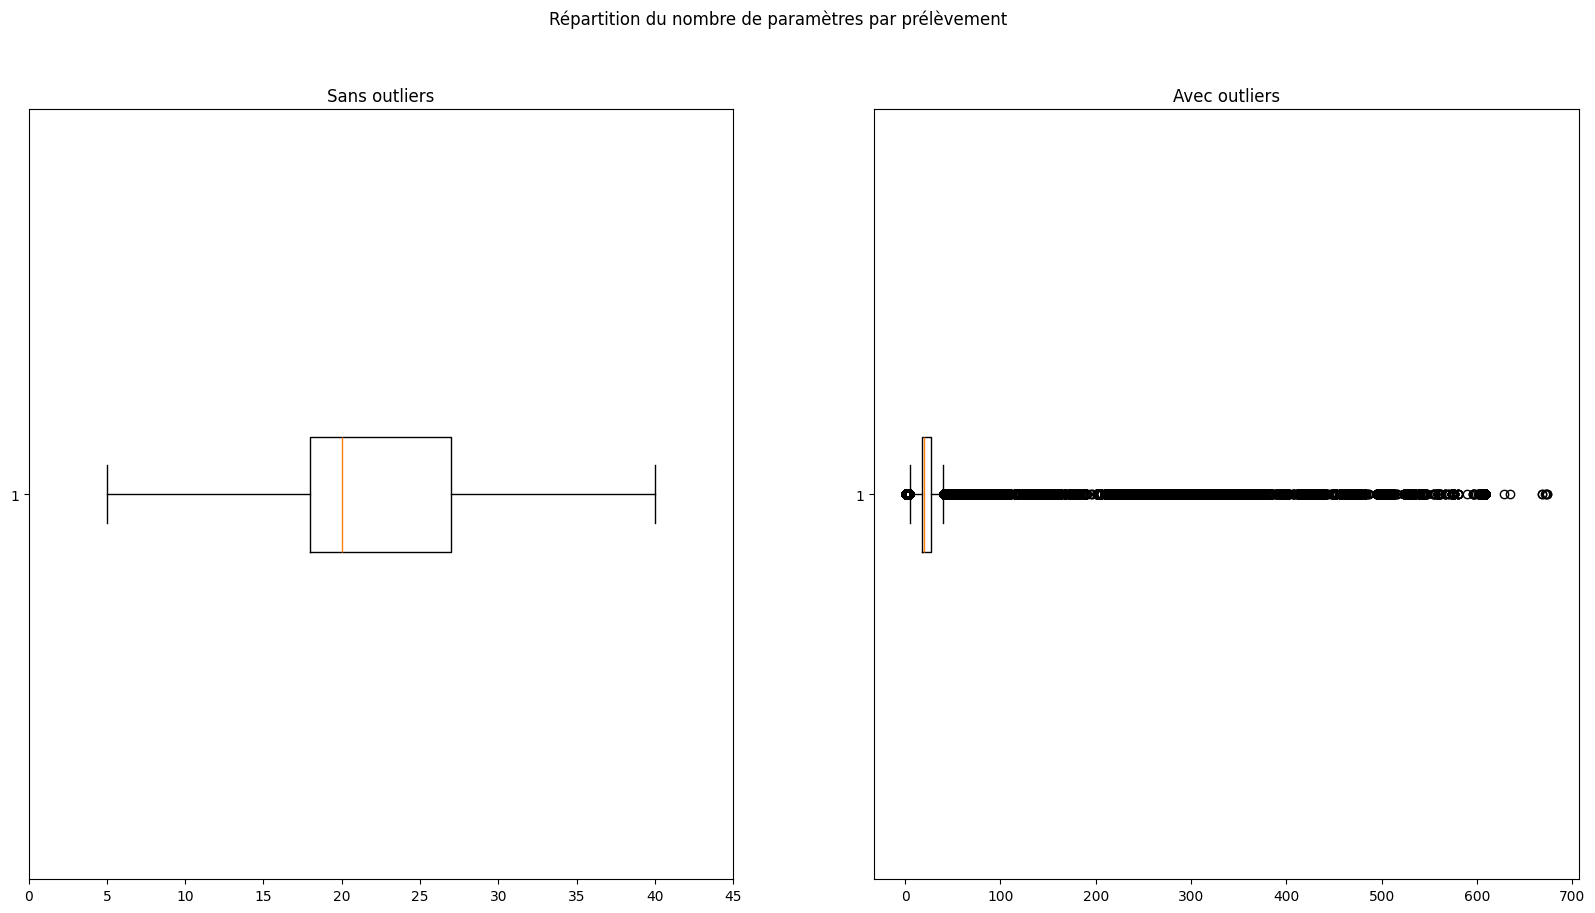

In [24]:
nb_param_par_prelev = resultats_avec_conclusion[['libminparametre','referenceprel']].groupby('referenceprel').count()
vals = nb_param_par_prelev.T.values[0]
print(nb_param_par_prelev.describe())

fig, axes = plt.subplots(1,2)
fig.set_figheight(10)
fig.set_figwidth(20)
fig.suptitle('Répartition du nombre de paramètres par prélèvement')
axes[0].boxplot(vals, orientation='horizontal', showfliers=False)
axes[1].boxplot(vals, orientation='horizontal', showfliers=True)
axes[0].title.set_text('Sans outliers')
axes[1].title.set_text('Avec outliers')
axes[0].set_xticks(np.arange(0, round((np.quantile(vals,0.75) + 1.5 * (np.quantile(vals,0.75) - np.quantile(vals,0.25)))) + 6, 5))
plt.show()

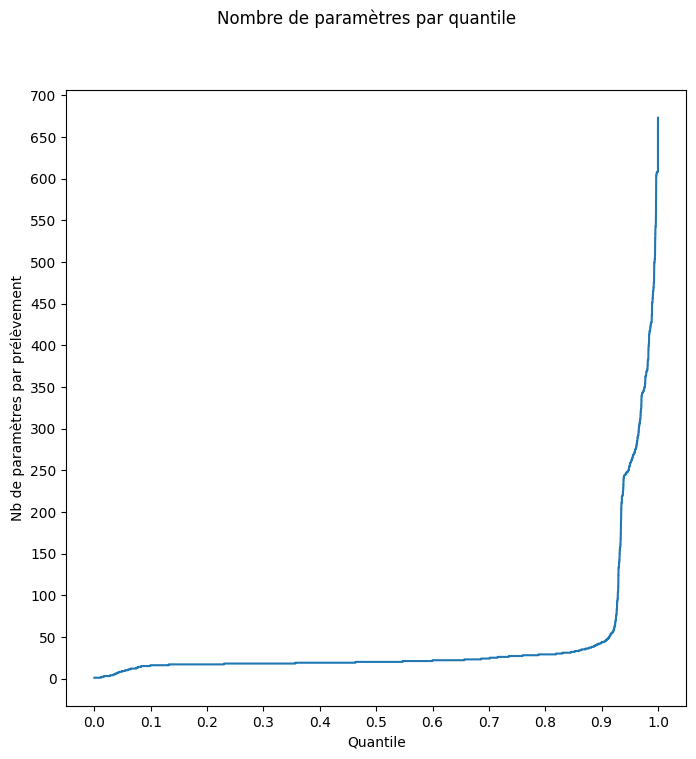

In [25]:
vals.sort()
abs = np.arange(0,len(vals),1)/len(vals)
yticks_scale = 50

fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(8)
fig.suptitle('Nombre de paramètres par quantile')
ax.plot(abs, vals)
ax.set_xticks(np.arange(0,1.1,0.1))
ax.set_yticks(np.arange(0,math.ceil(vals.max() / yticks_scale)*(yticks_scale+1),yticks_scale))
ax.set_xlabel('Quantile')
ax.set_ylabel('Nb de paramètres par prélèvement')
plt.show()


Par curiosité, on va également déterminer le top 10 des paramètres avec résultats hors seuil, pour chaque type de seuil.

In [26]:
resultats_avec_conclusion.loc[resultats_avec_conclusion['is_within_threshold_limitequal']==False,['libminparametre','cdparametresiseeaux']]\
.groupby('libminparametre').count().sort_values('cdparametresiseeaux',ascending=False).head(10).rename(columns={"cdparametresiseeaux": "Nb résultats hors seuil limitequal par paramètre"})

,Nb résultats hors seuil limitequal par paramètre
libminparametre,
Chlorothalonil R471811,4792
Chloridazone desphényl,4414
Escherichia coli /100ml - MF,3520
Entérocoques /100ml-MS,3235
Total des pesticides analysés,2764
Chloridazone méthyl desphényl,2561
Nitrates (en NO3),1706
Chlorothalonil R417888,1342
Turbidité néphélométrique NFU,559


In [27]:
resultats_avec_conclusion.loc[resultats_avec_conclusion['is_quality_acceptable']==False,['libminparametre','cdparametresiseeaux']]\
.groupby('libminparametre').count().sort_values('cdparametresiseeaux',ascending=False).head(10).rename(columns={"cdparametresiseeaux": "Nb résultats hors qualité par paramètre"})

,Nb résultats hors qualité par paramètre
libminparametre,
Aspect (qualitatif),3399
Odeur (qualitatif),3091
Saveur (qualitatif),2237
Couleur (qualitatif),1133
Présence de cyanobactéries (O/N),5
Odeur Saveur (qualitatif),3


# Analyse des prélèvements

Dans la doc officielle, on trouve le paragraphe suivant :  
"A noter que, dans ce jeu de données, l’ensemble des résultats d’analyses sont rapportés à l’unité de distribution concernée, cependant les prélèvements peuvent avoir été effectivement réalisés en amont du réseau de distribution, sur une installation de traitement, de production et de transport de l’eau (TTP), voire sur une installation de ressource en eau ou captage (CAP). En effet, suivant les paramètres concernés ou encore la configuration locale de production d’eau (présence de traitement, caractéristique de celui-ci…), les prélèvements réalisés dans le cadre du contrôle sanitaire le long de la chaîne de production (de la ressource au robinet) peuvent ou non être extrapolés à la qualité de l’eau mise à disposition du consommateur. Cette évaluation est réalisée localement par chaque ARS.

Dans le cas où le prélèvement est réalisé sur une autre installation, certains champs supplémentaires du fichier PLV fournissent des informations sur cette installation : ‘cdreseauamont‘ (code de l’installation amont), ‘nomreseauamont’ (nom de l’installation amont), ‘pourcentdebit’ (pourcentage de débit de l’installation amont : indique si l’installation amont alimente exclusivement ou en partie cette UDI). Lorsque les prélèvements ont été effectivement réalisés sur l’UDI concernée, ces champs sont vides."  

Traduction : en théorie, on devrait avoir une ligne par prélèvement et par UDI. Lorsque le prélèvement a été effectué en amont d'une UDI, et que l'ARS a extrapolé la qualité de l'eau à une UDI en aval du point de prélèvement, la ligne de prélèvement contient les informations sur le réseau en amont sur lequel le prélèvement a été effectué. Ce qui veut dire que pour un même prélèvement, on peut avoir plusieurs UDI rattachées à ce prélèvement, si l'ARS a fait l'extrapolation.

On va analyser ces cas d'extrapolation.

In [29]:
# on affiche tous les prélèvements qui sont non uniques
prelevements[prelevements['referenceprel'].duplicated(keep=False)].sort_values('referenceprel').head()

,cddept,cdreseau,inseecommuneprinc,nomcommuneprinc,cdreseauamont,nomreseauamont,pourcentdebit,referenceprel,dateprel,heureprel,conclusionprel,ugelib,distrlib,moalib,plvconformitebacterio,plvconformitechimique,plvconformitereferencebact,plvconformitereferencechim,de_partition,de_ingestion_date
1311,001,001000488,01032,BELIGNEUX,001000487,BELIGNEUX LA VALBONNE,0 %,00100138870,2024-01-18,09h37,Eau d'alimentation conforme aux exigences de q...,CC COTIERE A MONTLUEL (3CM) SOGEDO,SOGEDO LYON,CC DE LA CÔTIÈRE À MONTLUEL (3CM),C,C,C,C,2024,2025-02-07
1296,001,001000487,01032,BELIGNEUX,None,None,None,00100138870,2024-01-18,09h37,Eau d'alimentation conforme aux exigences de q...,CC COTIERE A MONTLUEL (3CM) SOGEDO,SOGEDO LYON,CC DE LA CÔTIÈRE À MONTLUEL (3CM),C,C,C,C,2024,2025-02-07
2410,001,001000763,01049,BOISSE (LA),001000761,LA BOISSE BAS SERVICE,0 %,00100138874,2024-01-18,10h35,Eau d'alimentation conforme aux exigences de q...,CC COTIERE A MONTLUEL (3CM) SOGEDO,SOGEDO LYON,CC DE LA CÔTIÈRE À MONTLUEL (3CM),C,C,C,C,2024,2025-02-07
2383,001,001000761,01049,BOISSE (LA),None,None,None,00100138874,2024-01-18,10h35,Eau d'alimentation conforme aux exigences de q...,CC COTIERE A MONTLUEL (3CM) SOGEDO,SOGEDO LYON,CC DE LA CÔTIÈRE À MONTLUEL (3CM),C,C,C,C,2024,2025-02-07
3292,001,001001028,01033,VALSERHONE,001001029,CHATILLON BAS SERVICE,50 %,00100138878,2024-01-23,13h22,Eau d'alimentation conforme aux limites de qua...,CC PAYS BELLEGARDIEN (CCPB),CC TERRE VALSERHONE - REGIE DES EAUX,CC TERRE VALSERHONE - REGIE DES EAUX,C,C,C,N,2024,2025-02-07


Si on analyse les 2 premières lignes, on retrouve en ligne 1 un prélèvement qui correspond à la description faite dans la doc : un prélèvement extrapolé à une UDI (réseau 001000488) dont le prélèvement à été fait en amont (réseau 001000487) ET en ligne 2, le même prélèvement associé au réseau en amont (réseau 001000487), ce qui veut dire que le réseau en amont est également une UDI.

Ce dataset représente donc la liste des associations entre les prélèvements (effectués sur une UDI ou non) et le réseau du point de prélèvement si c'est une UDI, ainsi que tous les réseaux UDI en aval du point de prélèvement que l'ARS locale a décidé d'extrapoler comme partageant la même qualité d'eau que le réseau d'origine.

##### Side note
Un élément troublant cependant est la valeur du débit de la ligne 1 : 0%.  
Voici la description du champ dans la doc : Caractérisation du lien entre l’installation amont (cdreseauamont) et l’unité de distribution (cdreseau), permettant d'indiquer la participation de l’installation amont (en %) au débit de l’installation aval.

Si on se base sur la description du document pour établir la signification des lignes 1 et 2, voici ce qu'on peut en déduire : un prélèvement a été effectué le 18/01/2024 à 9h37 sur l'UDI 001000487, ce réseau alimente 0% (!!!) du réseau 001000488 et l'ARS locale a décidé d'extrapoler la qualité de l'eau du réseau 001000487 au réseau 001000488  

Comment peut-on extrapoler la qualité de l'eau d'un réseau amont à un réseau en aval qui n'est pas du tout alimenté par celui-ci ?

On est devant un dilemme : soit la valeur des débits a une fiabilité très basse, soit l'ARS a pris des décisions illogiques. Il faudra sans doute prendre une décision sur comment on traite les associations UDI/prélèvements dont le débit vaut 0% du réseau amont.

A noter qu'il est donc tout à fait possible qu'un prélèvement ait eu lieu en amont d'une UDI (dans une TTP par exemple), que le prélèvement ait donné des résultats concluant à des dépassements de seuils sur certains paramètres, mais que l'ARS locale ait décidé de ne pas extrapoler la qualité de cette eau aux UDI en aval, auquel cas ces résultats n'apparaitraient pas dans le dataset des résultats.

##### End note

On peut donc déduire que si une association UDI/prélèvement n'a pas de réseau amont renseigné, le prélèvement a eu lieu dans l'UDI, sinon le prélèvement a eu lieu dans un réseau en amont.

On va donc établir la liste des prélèvements et le réseau dans lequel le prélèvement a eu lieu afin de faire de l'analyse sur les prélèvements uniquement.

In [30]:
# Cas 1 : le prélèvement a eu lieu dans une UDI
# on conserve que les colonnes concernant l'UDI et le prélèvement et en mettant de coté les conclusions qui ne nous intéressent pas pour le moment
liste_col = ['cddept','inseecommuneprinc','nomcommuneprinc','referenceprel','dateprel','heureprel','cdreseau']
prelevements_dans_UDI = prelevements.loc[prelevements['cdreseauamont'].isna(),liste_col].copy()

# Cas 2 : le prélèvement a eu lieu dans un réseau amont qui n'est pas une UDI, ie dans un réseau amont qui n'est pas dans la liste des UDI ayant un prélèvement
# on conserve que les colonnes concernant le réseau amont et le prélèvement et en mettant de coté les conclusions également
liste_col_2 = ['cddept','inseecommuneprinc','nomcommuneprinc','referenceprel','dateprel','heureprel','cdreseauamont','nomreseauamont']
liste_UDI_ayant_prelevement = prelevements_dans_UDI['cdreseau'].unique()
mask = prelevements['cdreseauamont'].apply(lambda x: x not in liste_UDI_ayant_prelevement if x is not None else False)
prelevements_hors_UDI = prelevements.loc[mask,liste_col_2].drop_duplicates().copy()

# note : on ne peut pas conserver le champ 'pourcentdebit' car c'est une caractéristique de l'association 'reseau/reseau amont' et on ne conserve ici que
# les informations du réseau dans lequel a eu lieu le prélèvement

Si toutes les assomptions sont correctes, on ne devrait avoir que des valeurs uniques de prélèvement dans les 2 cas, et la somme des lignes de chaque subset devrait être égale au nombre de valeurs uniques des références de prélèvements. On vérifie.

In [31]:
print(f'Nombre de prélèvements dans UDI non uniques : {prelevements_dans_UDI['referenceprel'].duplicated().sum()}')
print(f'Nombre de prélèvements hors UDI non uniques : {prelevements_hors_UDI['referenceprel'].duplicated().sum()}')
val = prelevements_dans_UDI.shape[0] + prelevements_hors_UDI.shape[0] == len(prelevements['referenceprel'].unique())
print(f'Nombre total de prélèvements égal aux nombres de prélèvements uniques : {val}')

Nombre de prélèvements dans UDI non uniques : 0
Nombre de prélèvements hors UDI non uniques : 0
Nombre total de prélèvements égal aux nombres de prélèvements uniques : True


Tout est ok. On peut concaténer les tables pour obtenir une table des prélèvements uniques avec le type de réseau.

In [32]:
prelevements_uniques = pd.concat([prelevements_dans_UDI,prelevements_hors_UDI], axis=0).reset_index(drop=True)
prelevements_uniques

,cddept,inseecommuneprinc,nomcommuneprinc,referenceprel,dateprel,heureprel,cdreseau,cdreseauamont,nomreseauamont
0,001,01007,AMBRONAY,00100139034,2024-01-23,11h27,001000003,NaN,NaN
1,001,01007,AMBRONAY,00100139393,2024-02-13,12h49,001000003,NaN,NaN
2,001,01007,AMBRONAY,00100140209,2024-04-05,07h27,001000003,NaN,NaN
3,001,01007,AMBRONAY,00100140543,2024-05-13,12h43,001000003,NaN,NaN
4,001,01007,AMBRONAY,00100140886,2024-06-11,11h53,001000003,NaN,NaN
...,...,...,...,...,...,...,...,...,...
287956,976,97606,CHIRONGUI,97600031198,2024-01-02,09h00,NaN,976003502,STATION CHIRONGUI
287957,976,97606,CHIRONGUI,97600031346,2024-01-15,11h05,NaN,976003502,STATION CHIRONGUI
287958,976,97606,CHIRONGUI,97600031641,2024-04-23,10h00,NaN,976003502,STATION CHIRONGUI
287959,976,97606,CHIRONGUI,97600031735,2024-05-28,11h29,NaN,976003502,STATION CHIRONGUI


Dans ce nouveau dataframe, on peut facilement identifier les prélèvements qui ont eu lieu dans une UDI et ceux en amont des UDI : si le champ cdreseau est renseigné, c'est une UDI, sinon c'est un champ en amont qui n'est pas une UDI.

On va s'intéresser à la part des prélèvements dans UDI et hors UDI.

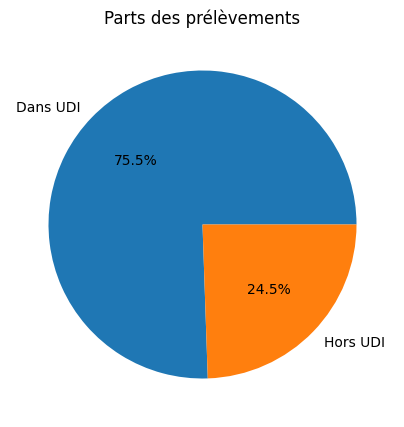

In [33]:
nb_prelevements_dans_udi = prelevements_uniques['cdreseau'].count()
nb_prelevements_hors_udi = prelevements_uniques['cdreseauamont'].count()

labels = 'Dans UDI', 'Hors UDI'
sizes = [nb_prelevements_dans_udi,nb_prelevements_hors_udi]
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(5)
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Parts des prélèvements')
plt.show()

On va s'intéresser maintenant à la répartition du nombre de prélèvements fait dans l'année par réseau, en distinguant les réseaux UDI et les réseaux non-UDI.

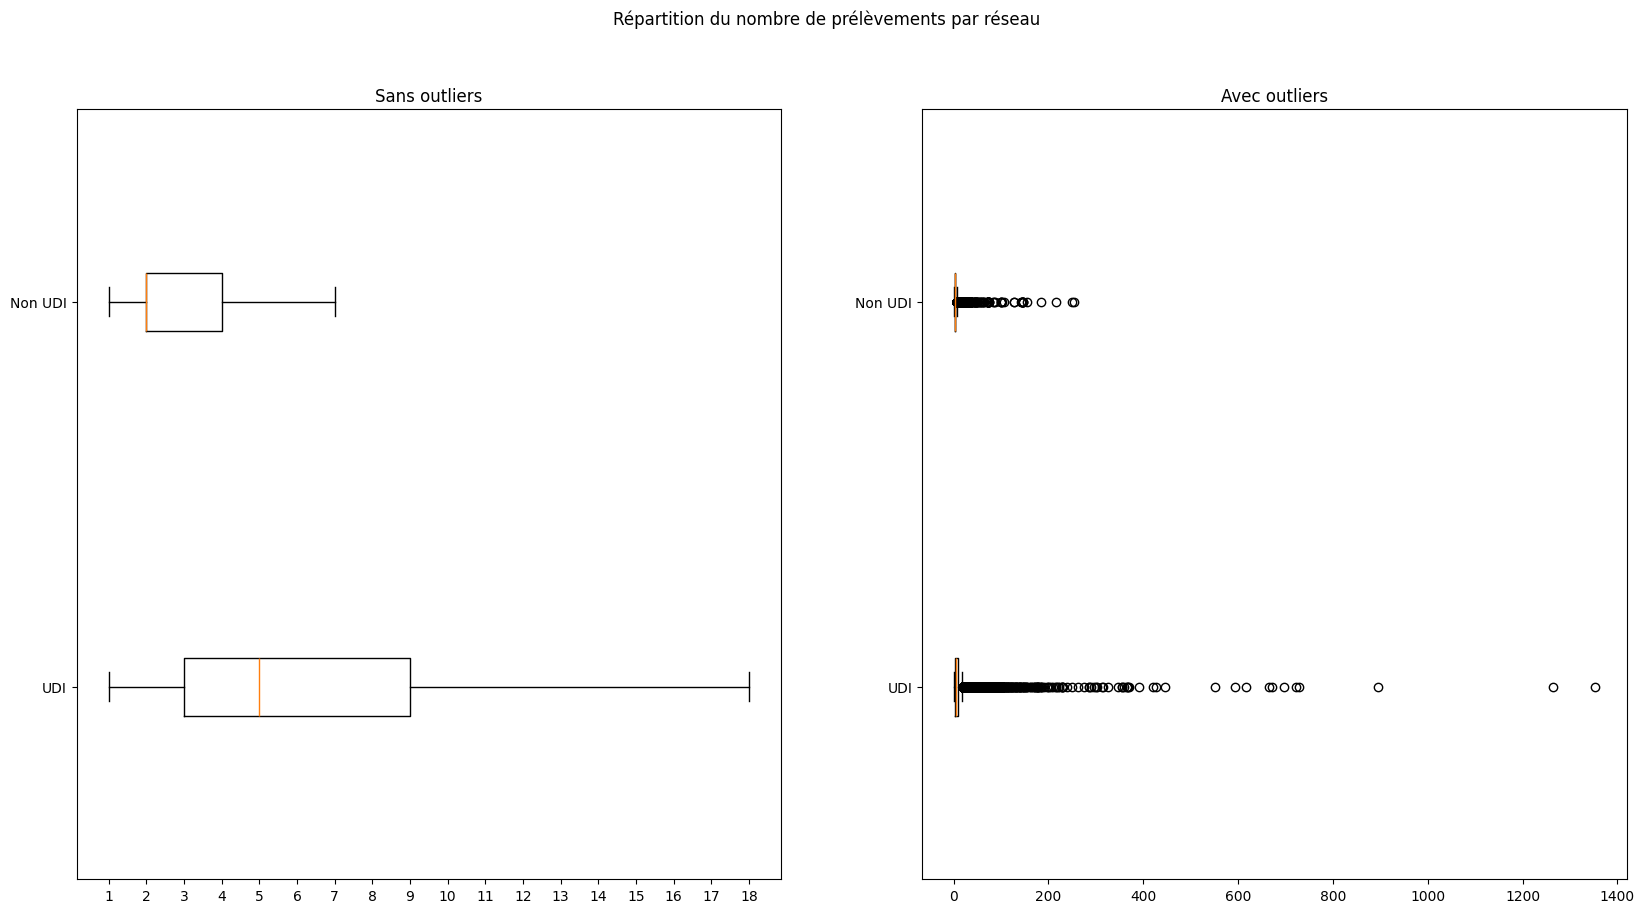

In [34]:
val_dans_udi = prelevements_uniques.loc[prelevements_uniques['cdreseau'].isna() == False,['cdreseau','referenceprel']].groupby('cdreseau').count().T.values[0]
val_hors_udi = prelevements_uniques.loc[prelevements_uniques['cdreseauamont'].isna() == False,['cdreseauamont','referenceprel']].groupby('cdreseauamont').count().T.values[0]


fig, axes = plt.subplots(1,2)
fig.set_figheight(10)
fig.set_figwidth(20)
fig.suptitle('Répartition du nombre de prélèvements par réseau')
axes[0].boxplot([val_dans_udi,val_hors_udi], orientation='horizontal',tick_labels=['UDI','Non UDI'], showfliers=False)
axes[1].boxplot([val_dans_udi,val_hors_udi], orientation='horizontal',tick_labels=['UDI','Non UDI'], showfliers=True)
axes[0].title.set_text('Sans outliers')
axes[1].title.set_text('Avec outliers')
axes[0].set_xticks(np.arange(val_dans_udi.min(), round((np.quantile(val_dans_udi,0.75) + 1.5 * (np.quantile(val_dans_udi,0.75) - np.quantile(val_dans_udi,0.25)))) + 1, 1))
plt.show()


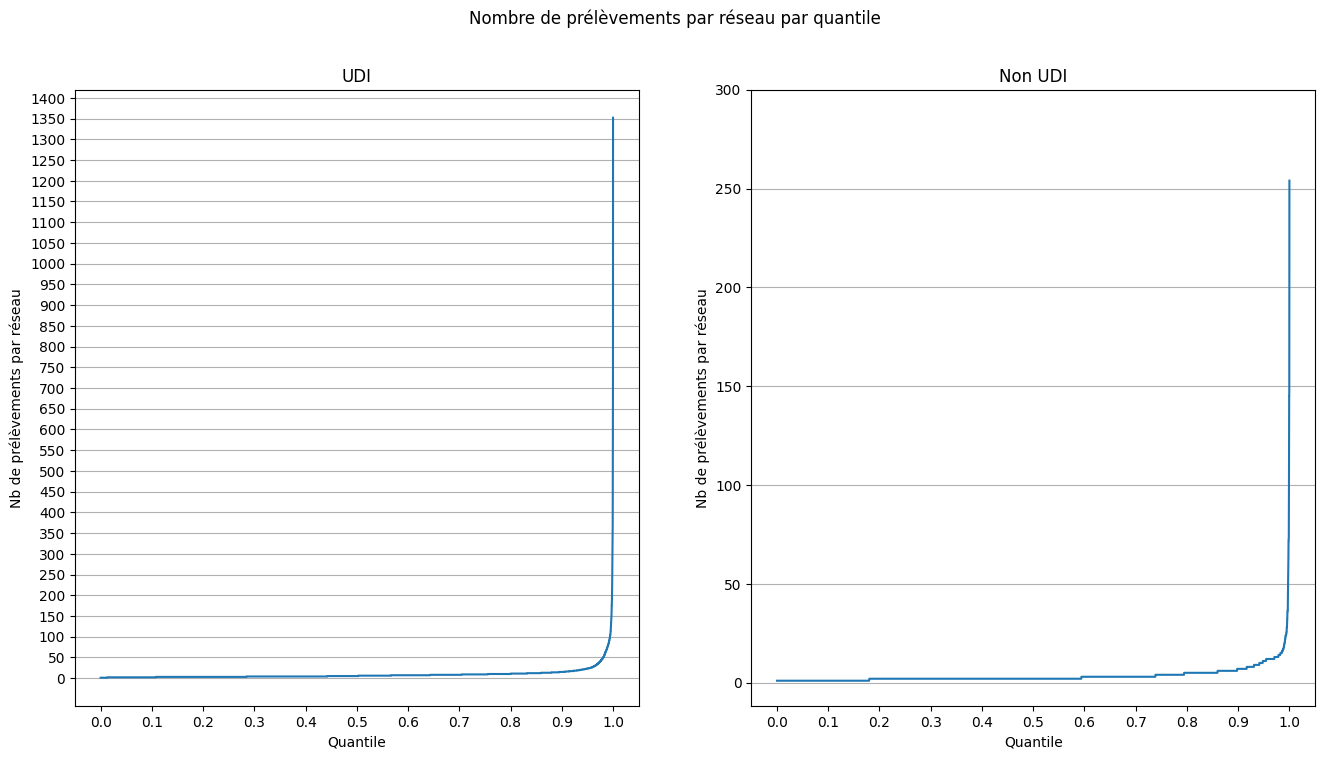

In [35]:
val_dans_udi.sort()
val_hors_udi.sort()

abs_dans_udi = np.arange(0,len(val_dans_udi),1)/len(val_dans_udi)
abs_hors_udi = np.arange(0,len(val_hors_udi),1)/len(val_hors_udi)
yticks_scale = 50

fig, axes = plt.subplots(1,2)
fig.set_figheight(8)
fig.set_figwidth(16)
fig.suptitle('Nombre de prélèvements par réseau par quantile')
axes[0].plot(abs_dans_udi, val_dans_udi)
axes[0].set_xticks(np.arange(0,1.1,0.1))
axes[0].set_yticks(np.arange(0,math.ceil(val_dans_udi.max() / yticks_scale)*(yticks_scale+1),yticks_scale))
axes[0].set_xlabel('Quantile')
axes[0].set_ylabel('Nb de prélèvements par réseau')
axes[0].title.set_text('UDI')
axes[1].plot(abs_hors_udi, val_hors_udi)
axes[1].set_xticks(np.arange(0,1.1,0.1))
axes[1].set_yticks(np.arange(0,math.ceil(val_hors_udi.max() / yticks_scale)*(yticks_scale+1),yticks_scale))
axes[1].set_xlabel('Quantile')
axes[1].set_ylabel('Nb de prélèvements par réseau')
axes[1].title.set_text('Non UDI')
axes[0].grid(axis='y')
axes[1].grid(axis='y')
plt.show()

On a donc des réseaux UDI qui font l'objet de plus d'un prélèvement par jour ouvré, pouvant aller jusqu'à plus de 5 prélèvements par jour ouvré. On va tenter de comprendre comment c'est possible en analysant les réseaux ayant le plus grand nomble de prélèvements.

In [36]:
# on établit le top 5 des réseaux UDI ayant le plus de prélèvements
prelevements_uniques.loc[prelevements_uniques['cdreseau'].isna() == False,['cdreseau','referenceprel']]\
.groupby('cdreseau').count().sort_values('referenceprel',ascending=False).head()

,referenceprel
cdreseau,
092000054,1352
069000069,1265
093000089,895
031000006,729
095000386,722


In [37]:
# observons le #1
prelevements_uniques[prelevements_uniques['cdreseau'] == '092000054']

,cddept,inseecommuneprinc,nomcommuneprinc,referenceprel,dateprel,heureprel,cdreseau,cdreseauamont,nomreseauamont
204426,092,92012,BOULOGNE-BILLANCOURT,09200141017,2024-01-03,08h25,092000054,NaN,NaN
204427,092,92012,BOULOGNE-BILLANCOURT,09200141018,2024-01-03,09h38,092000054,NaN,NaN
204428,092,92014,BOURG-LA-REINE,09200141019,2024-01-04,10h20,092000054,NaN,NaN
204429,092,92014,BOURG-LA-REINE,09200141020,2024-01-04,10h20,092000054,NaN,NaN
204430,092,92032,FONTENAY-AUX-ROSES,09200141021,2024-01-04,12h40,092000054,NaN,NaN
...,...,...,...,...,...,...,...,...,...
205773,092,92046,MALAKOFF,09200146274,2024-12-18,11h19,092000054,NaN,NaN
205774,092,92049,MONTROUGE,09200146275,2024-12-18,14h41,092000054,NaN,NaN
205775,092,92049,MONTROUGE,09200146276,2024-12-18,12h51,092000054,NaN,NaN
205776,092,92007,BAGNEUX,09200146277,2024-12-17,10h18,092000054,NaN,NaN


On remarque plusieurs choses :  
- plusieurs prélèvements peuvent être établis au même moment et dans le même lieu (ligne 3 et 4)
- pour un même réseau, on a plusieurs communes possibles dans lesquelles effectuer un prélèvement  

Lorsqu'on regarde la description du champ 'nomcommuneprinc' dans la documentation officielle, on trouve : "Nom de la commune où se trouve le point de surveillance sur lequel le prélèvement a eu lieu"  

On a donc des réseaux qui peuvent avoir plusieurs points de surveillance. Analysons donc le nombre de points de surveillance par réseau.

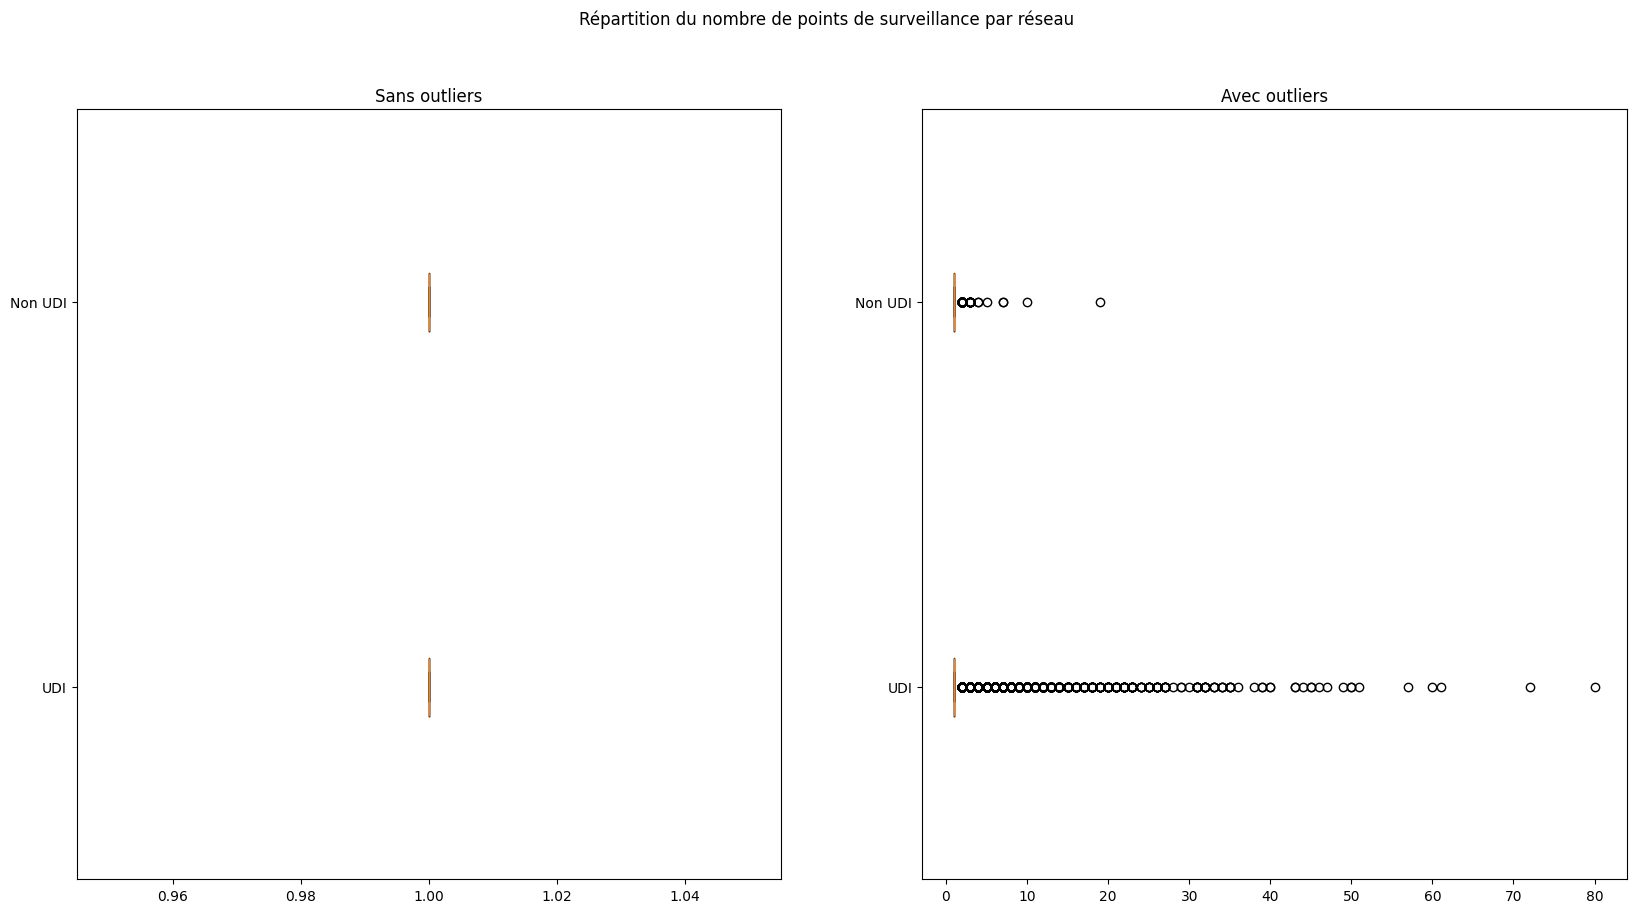

In [38]:
nb_point_surv_dans_udi = prelevements_uniques.loc[prelevements_uniques['cdreseau'].isna() == False,['cdreseau','nomcommuneprinc']]\
.drop_duplicates().groupby('cdreseau').count()
nb_point_surv_hors_udi = prelevements_uniques.loc[prelevements_uniques['cdreseauamont'].isna() == False,['cdreseauamont','nomcommuneprinc']]\
.drop_duplicates().groupby('cdreseauamont').count()

fig, axes = plt.subplots(1,2)
fig.set_figheight(10)
fig.set_figwidth(20)
fig.suptitle('Répartition du nombre de points de surveillance par réseau')
axes[0].boxplot([nb_point_surv_dans_udi.T.values[0],nb_point_surv_hors_udi.T.values[0]], orientation='horizontal',tick_labels=['UDI','Non UDI'], showfliers=False)
axes[1].boxplot([nb_point_surv_dans_udi.T.values[0],nb_point_surv_hors_udi.T.values[0]], orientation='horizontal',tick_labels=['UDI','Non UDI'], showfliers=True)
axes[0].title.set_text('Sans outliers')
axes[1].title.set_text('Avec outliers')
plt.show()

On a une large majorité de réseaux ayant un seul point de surveillance. On va déterminer la part des réseaux ayant plus d'un point de surveillance.

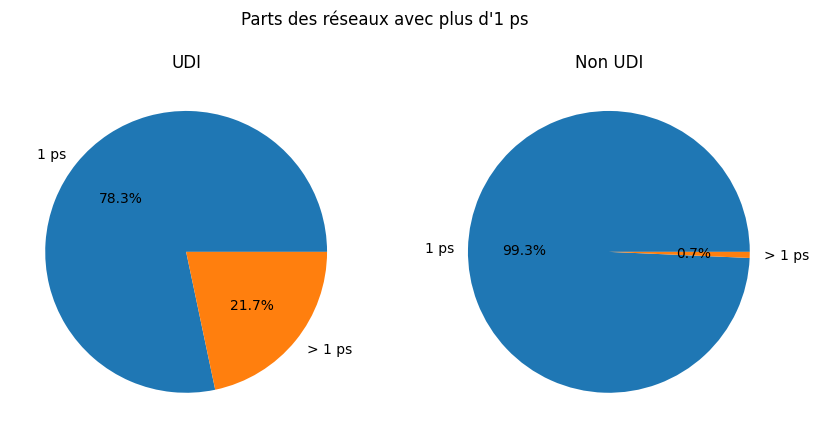

In [39]:
nb_reseaux_udi_avec_1_ps = nb_point_surv_dans_udi[nb_point_surv_dans_udi['nomcommuneprinc'] == 1].count().values[0]
nb_reseaux_udi_avec_plus_de_1_ps = nb_point_surv_dans_udi[nb_point_surv_dans_udi['nomcommuneprinc'] > 1].count().values[0]

nb_reseaux_non_udi_avec_1_ps = nb_point_surv_hors_udi[nb_point_surv_hors_udi['nomcommuneprinc'] == 1].count().values[0]
nb_reseaux_non_udi_avec_plus_de_1_ps = nb_point_surv_hors_udi[nb_point_surv_hors_udi['nomcommuneprinc'] > 1].count().values[0]

labels = '1 ps', '> 1 ps'
fig, axes = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(10)
axes[0].pie([nb_reseaux_udi_avec_1_ps,nb_reseaux_udi_avec_plus_de_1_ps], labels=labels, autopct='%1.1f%%')
axes[0].title.set_text('UDI')
axes[1].pie([nb_reseaux_non_udi_avec_1_ps,nb_reseaux_non_udi_avec_plus_de_1_ps], labels=labels, autopct='%1.1f%%')
axes[1].title.set_text('Non UDI')
fig.suptitle('Parts des réseaux avec plus d\'1 ps')
plt.show()

Comme on peut avoir des points de surveillance d'un même réseau situés dans plusieurs communes, une question légitime est : une commune peut-elle accueillir des points de surveillance de réseaux différents ? On va donc calculer le nombre de réseaux différents par commune de point de surveillance.

In [40]:
t = prelevements_uniques.loc[prelevements_uniques['cdreseau'].isna() == False,['nomcommuneprinc','cdreseau']]\
.drop_duplicates().groupby('nomcommuneprinc').count()
print(f"Nombre de communes avec points de surveillance de réseaux différents : {t[t['cdreseau'] > 1].count().values[0]}")

Nombre de communes avec points de surveillance de réseaux différents : 6325


Pour résumer :
- les prélèvements sont effectués dans des points de surveillance qui dépendent d'un réseau
- le réseau peut être une UDI ou une unité en amont (catégorisé "Non UDI" dans l'étude)
- il peut y avoir plusieurs prélèvements différents effectués au même endroit au même moment
- un réseau peut avoir plusieurs points de surveillance situés dans des communes différentes
- une commune peut avoir des points de surveillance affiliés à des réseaux différents
- un prélèvement et ses résultats associés peuvent être extrapolés à tout ou partie des réseaux en aval du point de surveillance
- les réseaux extrapolés ne sont pas forcément alimenté à 100% par le réseau amont objet du prélèvement

Cela pose plusieurs questions : 
- quelle représentation spatiale des résultats (qui dépendent des réseaux) ? sachant qu'un réseau UDI peut alimenter plusieurs communes ou seulement une partie de commune
- que faire en cas de résultats contradictoire entre plusieurs prélèvements effectués sur un même réseau ?
- les prélèvements sont situés également dans le temps, doit on représenter les résultats à un temps donné ? ou uniquement les derniers résultats connus ? ou l'évolution des résultats dans le temps ?
- que faire de l'extrapolation des résultats aux réseaux en aval ? un résultat hors seuil de 10% en amont donne-t-il forcément un résultat hors seuil si le réseau en aval n'est alimenté qu'à 30% par ce réseau ? (dilution ?)

In [41]:
end_time = datetime.datetime.now()
end_time - start_time

datetime.timedelta(seconds=1378, microseconds=242406)